In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw5/data
!rm hw3_data.zip
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 457 (delta 119), reused 96 (delta 80), pack-reused 242
Receiving objects: 100% (457/457), 73.71 MiB | 23.19 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Checking out files: 100% (68/68), done.
--2022-03-30 06:51:12--  https://docs.google.com/uc?export=download&confirm=t&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 74.125.202.101, 74.125.202.138, 74.125.202.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.202.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hc1nguhshc67ma3g0mg9f41t3jldpvha/1648623000000/06419056966375271799/*/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2022-03-30 06:51:12--  https://doc-08-

In [2]:
from dul_2021.utils.hw5_utils import *

In [3]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [11., 8.]

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Question 1: VAEs on Images
In this question, you will train VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

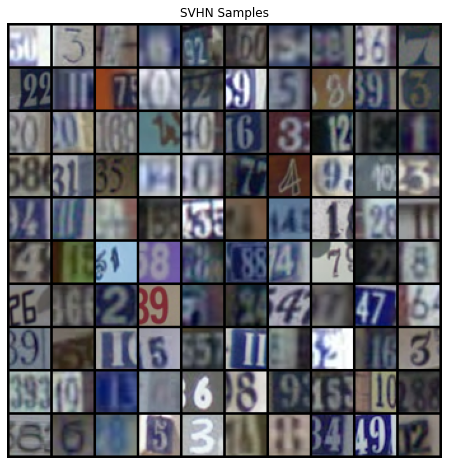

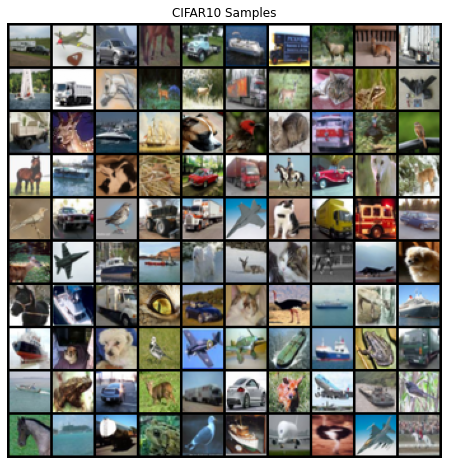

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [5]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [7]:
class Encoder(nn.Module):
  def __init__(self, latent_dim=16):
    super().__init__()
    conv_seq = nn.Sequential(self.block(3, 64, stride=1),
                             # 32 x 32
                             self.block(64, 128),
                             # 16 x 16 
                             self.block(128, 256),
                             # 8 x 8
                             self.block(256, 256))

    self.encoder = nn.Sequential(conv_seq, 
                                 nn.Flatten(), 
                                 nn.Linear(4 * 4 * 256, 2 * latent_dim))
    
  def block(self, in_channels, out_channels, stride=2, padding=1):
    conv = nn.Conv2d(in_channels, out_channels, 3, stride, padding)
    return nn.Sequential(conv, nn.ReLU())

  def forward(self, x):
    return self.encoder(x)

In [8]:
class Decoder(nn.Module):
  def __init__(self, latent_dim=16):
    super().__init__()
    self.linear = nn.Sequential(nn.Linear(latent_dim, 4 * 4 * 256),
                                nn.ReLU())
        
    self.conv_seq = nn.Sequential(self.block(256, 256), 
                                  self.block(256, 128), 
                                  self.block(128, 64),
                                  nn.Conv2d(64, 3, 3, 1, 1))
        
  def block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    conv_t = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
    return nn.Sequential(conv_t, nn.ReLU())

  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 256, 4, 4)
    x = self.conv_seq(x)
    return (F.tanh(x) + 1) * 0.5

In [18]:
class VAE(nn.Module):
  def __init__(self, latent_dim=32, device="cuda"):
    super().__init__()
    self.l_dim = latent_dim
    self.device = device
    self.encoder = Encoder(latent_dim).to(device)
    self.decoder = Decoder(latent_dim).to(device)

    self.opt = torch.optim.Adam(self.parameters(), 1e-3)   
    self.prior = torch.distributions.MultivariateNormal(torch.zeros(self.l_dim), 
                                                        torch.diag(torch.ones(self.l_dim)))

  def forward(self, x):
    # Get mean and variance
    y = self.encoder(x)
    μ, ln_σ = torch.chunk(y, 2, 1)
    σ = torch.exp(ln_σ)

    # Reparametrization
    z = μ + σ * torch.randn_like(σ) 

    # Reconstruction
    d = self.decoder(z)

    return y, z, d

  def sample(self, size: int):
    with torch.no_grad():
      z = self.prior.sample((size,)).to(self.device)
      y = self.decoder(z)

    return to_numpy(y)

  def step(self, loss):
    self.opt.zero_grad()
    loss.backward()
    self.opt.step()

  def compute_normal_dkl(self, μ, ln_σ):
    """
    Compute KL divergence as sum of D_KL of independent variables
    """
    mask = torch.sign(ln_σ)
    
    log_var = 2 * ln_σ
    dkl = - log_var
    dkl += torch.exp(log_var)
    dkl += μ ** 2
    dkl -= 1

    return 0.5 * dkl.sum(dim=1)

## Data utils

In [19]:
def transform(data: numpy.ndarray, batch_size=128):
  data = data.astype(np.float32) / 255
  data = torch.from_numpy(data)
  data = data.permute((0, 3, 1, 2))

  dataset = TensorDataset(data)
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

  return data_loader, dataset

In [20]:
def to_numpy(x: torch.Tensor) -> numpy.ndarray:
  x *= 255
  x = x.permute((0, 2, 3, 1))
  x = x.cpu().numpy()
  x = x.astype(np.uint8)
  return x

## Model utils

In [21]:
def interpolate(model, dataset):
  idx = np.random.randint(0, len(dataset), 20)
  X = dataset[idx][0].to(device)
  Y = torch.empty((10, 10, 3, 32, 32), device=device)

  Y[:, 0] = X[:10]
  Y[:, 9] = X[10:]

  with torch.no_grad():
    _, z, _ = model(X)
    z1, z2 = torch.chunk(z, 2, 0)
    direction = (z2 - z1) / 9

    for j in range(1, 9):
      Y[:, j] = model.decoder(z1 + j * direction)

  Y = Y.reshape(-1, 3, 32, 32)
  
  return to_numpy(Y)

In [22]:
def reconstruct(model, dataset, K=50):
  R = torch.empty((2 * K, 3, 32, 32), device=device)

  with torch.no_grad():
    size = len(dataset)
    idx = np.random.randint(0, size, K)
    original = dataset[idx][0].to(device)

    _, _, rec = model(original)

  for i in range(K):
    R[2 * i] = original[i]
    R[2 * i + 1] = rec[i]

  return to_numpy(R)

## Solution

In [31]:
def q1_a(train_data, test_data, dset_id):
  """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
  """
    
  def iterate_over(model, x):
    y, _, x_rec = model(x)
    
    # Compute loss
    
    # KL (q_zx || p_z)
    μ, ln_σ = torch.chunk(y, 2, 1)
    kld = model.compute_normal_dkl(μ, ln_σ).mean()
        
    # MSE (x|z, x)
    mse = (x - x_rec) ** 2
    mse = mse.sum(dim=(1, 2, 3)).mean()
    
    return mse, kld

  # Hyperparameters
  num_epochs = 30
  batch_size = 128
  latent_dim = 32
  kl_coef = .2

  # Define model and losses
  vae = VAE(latent_dim, device).to(device)

  # Dataloaders and datasets
  train_dl, train_dataset = transform(train_data)
  test_dl, test_dataset = transform(test_data)

  # Loss records
  test_mse, train_mse = [], []
  test_kld, train_kld = [], []

  # Train loop
  for epoch in range(num_epochs + 1):
    print(f"EPOCH : {epoch}")

    # Train dataset
    if epoch > 0:
      for x in train_dl:
        mse, kld = iterate_over(vae, x[0].to(device))        
        loss = mse + kl_coef * kld
        vae.step(loss)

        train_mse.append(mse.item())
        train_kld.append(kld.item())

      print(f"\tMSE = {np.mean(train_mse[-50:]):.5f}")
      print(f"\tDKL = {np.mean(train_kld[-50:]):.5f}")
        
    # Test dataset
    test_mse.append(0)
    test_kld.append(0)
    for x in test_dl:
      with torch.no_grad():
        mse, kld = iterate_over(vae, x[0].to(device))
            
      test_mse[-1] += mse.item()
      test_kld[-1] += kld.item() 

    test_mse[-1] /= len(test_dl)
    test_kld[-1] /= len(test_dl)

  # Accumulate all losses
  train_loss = [mse + kld for mse, kld in zip(train_mse, train_kld)]
  train_loss = list(zip(train_loss, train_mse, train_kld))
  train_loss = np.array(train_loss)

  test_loss = [mse + kld for mse, kld in zip(test_mse, test_kld)]
  test_loss = list(zip(test_loss, test_mse, test_kld))
  test_loss = np.array(test_loss)

  # Sample, reconstruct, interpolate
  samples = vae.sample(100)

  reconstructions = reconstruct(vae, test_dataset)

  interpolations = interpolate(vae, test_dataset)

  return train_loss, test_loss, samples, reconstructions, interpolations

# Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

## SVHN

EPOCH : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


EPOCH : 1
	MSE = 81.61298
	DKL = 16.27984
EPOCH : 2
	MSE = 41.91279
	DKL = 18.88269
EPOCH : 3
	MSE = 33.45972
	DKL = 21.16755
EPOCH : 4
	MSE = 29.19204
	DKL = 22.45554
EPOCH : 5
	MSE = 25.55875
	DKL = 24.30187
EPOCH : 6
	MSE = 22.94561
	DKL = 26.11962
EPOCH : 7
	MSE = 21.06975
	DKL = 28.04002
EPOCH : 8
	MSE = 19.89727
	DKL = 28.55872
EPOCH : 9
	MSE = 19.74722
	DKL = 29.41258
EPOCH : 10
	MSE = 18.56611
	DKL = 29.43448
EPOCH : 11
	MSE = 18.37250
	DKL = 29.74820
EPOCH : 12
	MSE = 17.51894
	DKL = 29.71838
EPOCH : 13
	MSE = 17.05124
	DKL = 30.43686
EPOCH : 14
	MSE = 16.75022
	DKL = 30.34705
EPOCH : 15
	MSE = 16.27359
	DKL = 30.78247
EPOCH : 16
	MSE = 16.24421
	DKL = 31.05485
EPOCH : 17
	MSE = 15.90193
	DKL = 31.37285
EPOCH : 18
	MSE = 15.35576
	DKL = 31.71648
EPOCH : 19
	MSE = 15.31846
	DKL = 31.96416
EPOCH : 20
	MSE = 15.06816
	DKL = 32.05586
EPOCH : 21
	MSE = 14.44613
	DKL = 32.30684
EPOCH : 22
	MSE = 14.43132
	DKL = 32.58445
EPOCH : 23
	MSE = 14.13531
	DKL = 32.72144
EPOCH : 24
	MSE = 13

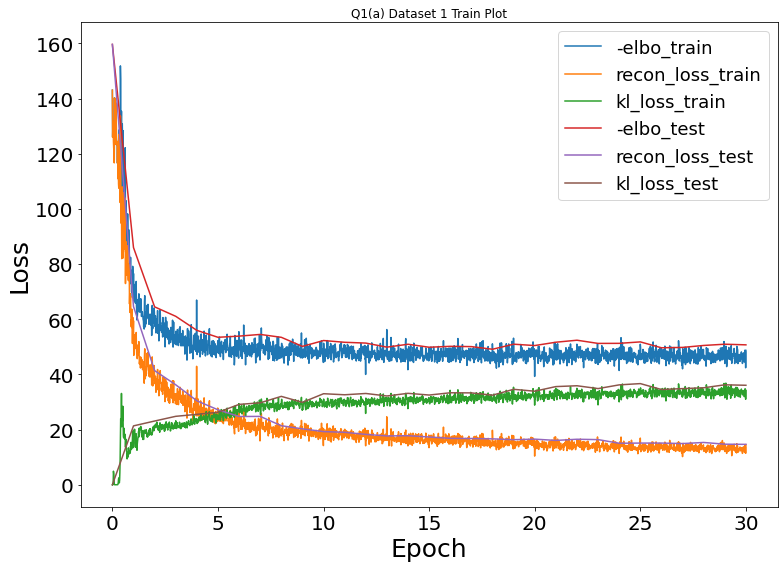

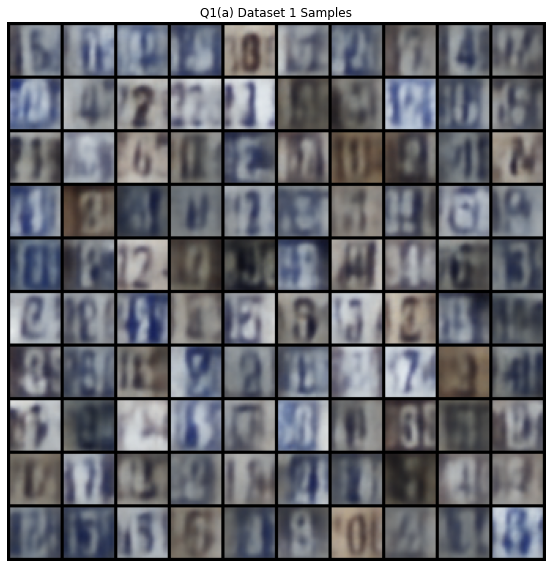

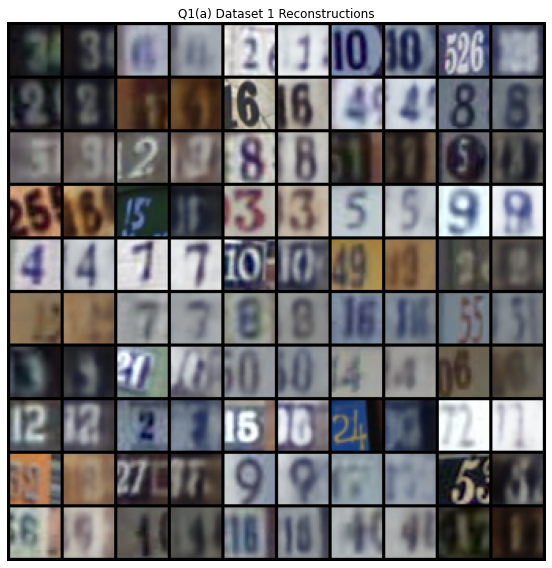

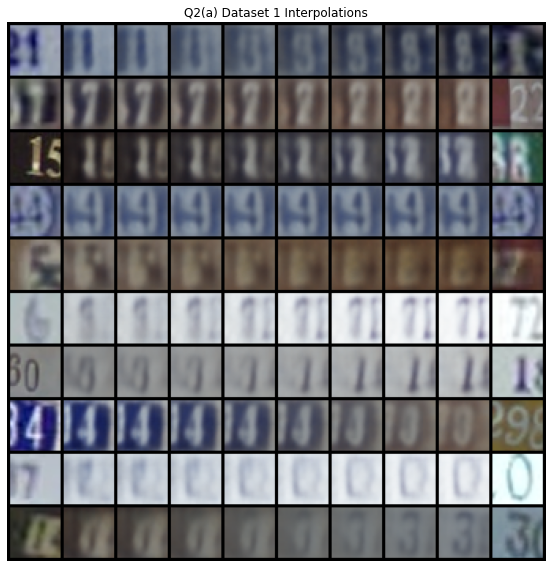

In [29]:
q1_save_results('a', 1, q1_a) # All losses in log_space

## CIFAR-10

EPOCH : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


EPOCH : 1
	MSE = 58.94991
	DKL = 44.20958
EPOCH : 2
	MSE = 45.74915
	DKL = 49.25033
EPOCH : 3
	MSE = 42.27522
	DKL = 50.30006
EPOCH : 4
	MSE = 40.36010
	DKL = 50.37414
EPOCH : 5
	MSE = 40.16187
	DKL = 50.25018
EPOCH : 6
	MSE = 39.84068
	DKL = 50.01917
EPOCH : 7
	MSE = 39.63447
	DKL = 49.98766
EPOCH : 8
	MSE = 39.54418
	DKL = 50.01979
EPOCH : 9
	MSE = 39.51338
	DKL = 49.91765
EPOCH : 10
	MSE = 39.11332
	DKL = 49.92205
EPOCH : 11
	MSE = 38.59959
	DKL = 49.80209
EPOCH : 12
	MSE = 38.51022
	DKL = 49.82723
EPOCH : 13
	MSE = 38.18071
	DKL = 49.76178
EPOCH : 14
	MSE = 38.22672
	DKL = 49.63547
EPOCH : 15
	MSE = 37.71361
	DKL = 49.74004
EPOCH : 16
	MSE = 38.13911
	DKL = 50.08266
EPOCH : 17
	MSE = 37.58908
	DKL = 49.65050
EPOCH : 18
	MSE = 37.97063
	DKL = 49.85951
EPOCH : 19
	MSE = 38.19538
	DKL = 50.02570
EPOCH : 20
	MSE = 37.45553
	DKL = 49.93565
EPOCH : 21
	MSE = 37.37120
	DKL = 49.91943
EPOCH : 22
	MSE = 37.51346
	DKL = 49.78899
EPOCH : 23
	MSE = 37.76704
	DKL = 49.82789
EPOCH : 24
	MSE = 37

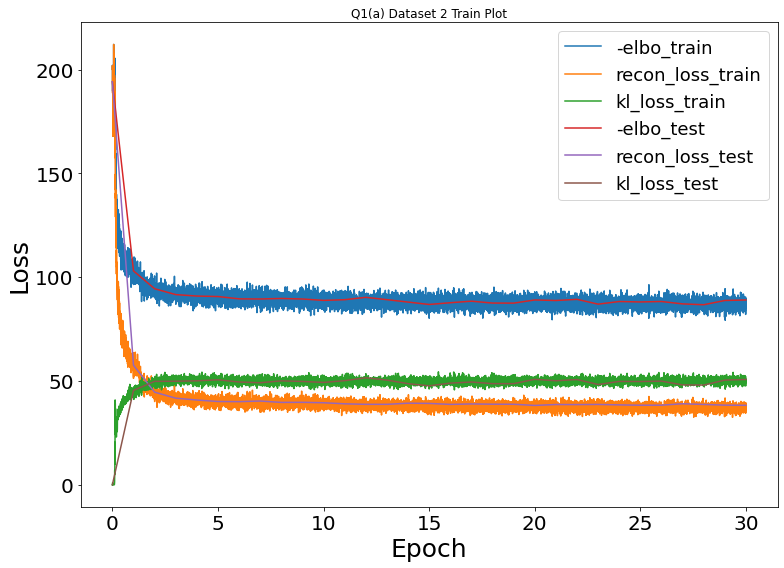

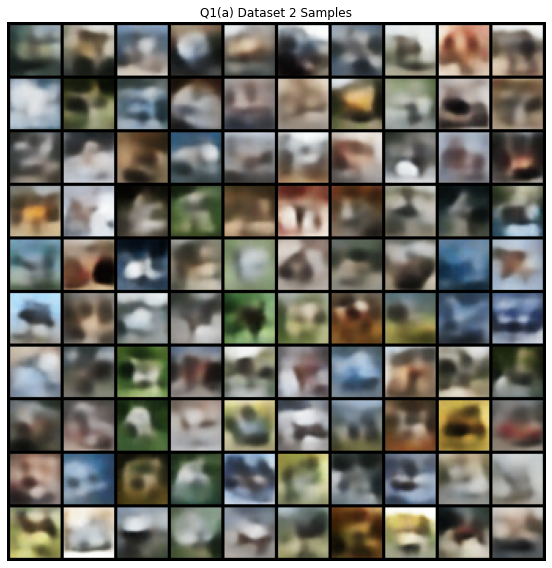

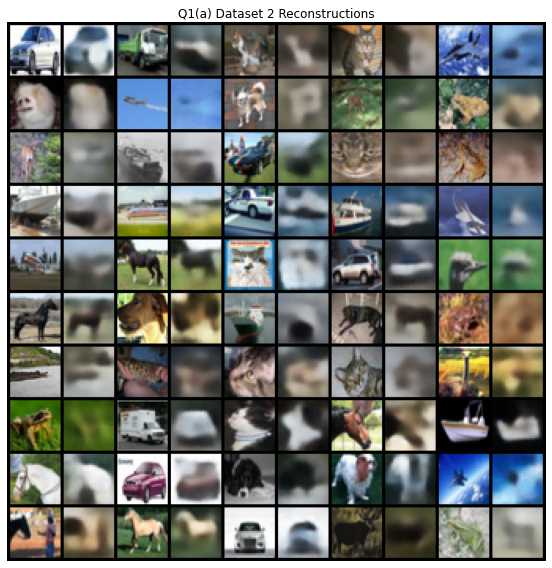

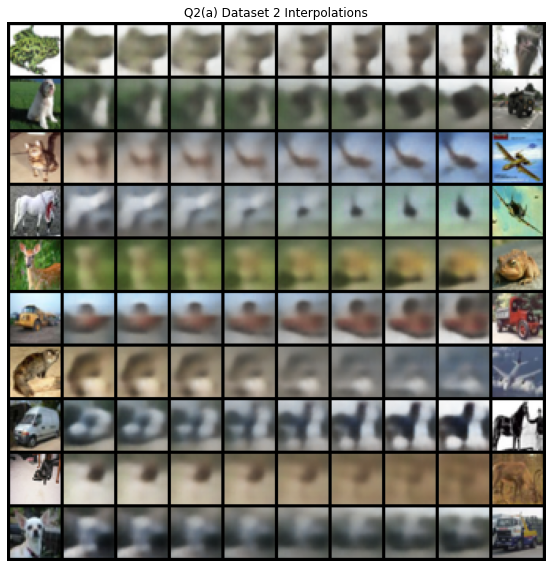

In [32]:
q1_save_results('a', 2, q1_a) # All losses in log space